# Variational Autoencoders
## Deep Learning Project 6: Developing a VAE
---


In this project, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.

### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [ ]:
# load necessary libriaries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [ ]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this project, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

11501568/11490434 [==============================] - 0s 0us/step


## Exercise 1: Variational Autoencoder: Reparameterization Trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.


In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

Now, We are going to complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method, and make sure the output shape is the proper one.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #compute and return z
        z_mean = inputs[0]
        z_var = inputs[1]
        return z_mean + tf.exp(z_var / 2) * tf.keras.backend.random_normal(tf.shape(z_mean))
        # ...

## Exercise 2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in Project 5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

Time to complete the code defining a deep encoder and the Dense layers that model `z_mean` and `z_var`. Explanation of choice for the number of layers, the layers sizes and the activation functions. 

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))

x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)


z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x) #Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x) #Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          32896       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                            

**Explanation:**

I want to start with which parameters important for us. In this example(Exercise 2), I specifically focused on **Number of Layer**, **Layer Size** and **Activation function**. 

1.   Firstly, Number of Layer:
  - In my model there is layer in Encoder part because of that I thought that it was a sufficient number to allow the model to encode the most relevant information in the latent space.

2.   Layer Size:
  - "The optimal size of the hidden layer is usually between the size of the input and size of the output layers." Mostly I see this sentence when I searched about layer size on internet. I used intuitively these numbers because they worked really well in Project 5. Also the transition from one level to another is substantial in terms of size. The layers sizes have been chosen in a way that allow the model to learn only the most important features of the data and to discard the useless ones.

3.   Activation Function:   
  - At this point most important question is "Why we need nonlinear activation function?". 
  - It is an easy example because we see this answer throughout our projects many times. The significance of the activation function lies in making a given model learn and execute difficult tasks. Further, a non-linear activation function allows the stacking of multiple layers of neurons to create a deep neural network, which is required to learn complex data sets with high accuracy.
  - The reason I chose the hyperbolic tangent is because it better deals with the vanishing gradient problem.As in my previous answer, I tried this function in the previous assignment and I continued to use tanh activation function because I got successful results. I could also use the sigmoid activation function instead.As a matter of fact, I also tried it in the examples below


## Exercise 3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

Defining the decoder. Explanation of my choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer). Answer in the text cell below.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))


x = tf.keras.layers.Dense(64, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(256, activation='tanh')(x)


decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x) 

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 784)               201488    
                                                                 
Total params: 243,024
Trainable params: 243,024
Non-trainable params: 0
_________________________________________________________________


**Explanation:** 

The decoder needs to be the reverse of the encoder. The decoder maps the encoded state of a fixed shape to a variable-length sequence.To generate a variable-length sequence token by token, every time the decoder may map an input (e.g., the generated token at the previous time step) and the encoded state into an output token at the current time step.

I used the tanh activation function again in other layers except the decoded layer. However, for the decoded layer, I want to use the sigmoid activation as we want our output to be in the same range as our normalised input, which is [0,1]. The sigmoid function gives in output value between 0 and 1. So, it allows to predict the pixels of the output image.For this reason, the tanh function is not suitable for the last layer. 

## Exercise 4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

I will implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # record operations for automatic differentiation
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(data.shape[1] * tf.keras.losses.binary_crossentropy(data, reconstruction)) 

            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var)), axis=1)) 

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # optimize the custom loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/30
469/469 [==============================] - 6s 4ms/step - loss: 201.9299 - reconstruction_loss: 198.2260 - kl_loss: 3.7038
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 169.9574 - reconstruction_loss: 165.3966 - kl_loss: 4.5608
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 158.1049 - reconstruction_loss: 152.9945 - kl_loss: 5.1104
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 152.6076 - reconstruction_loss: 147.1203 - kl_loss: 5.4873
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 149.3681 - reconstruction_loss: 143.6160 - kl_loss: 5.7521
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 147.0256 - reconstruction_loss: 141.1112 - kl_loss: 5.9144
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 145.3212 - reconstruction_loss: 139.2700 - kl_loss: 6.0512
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - l

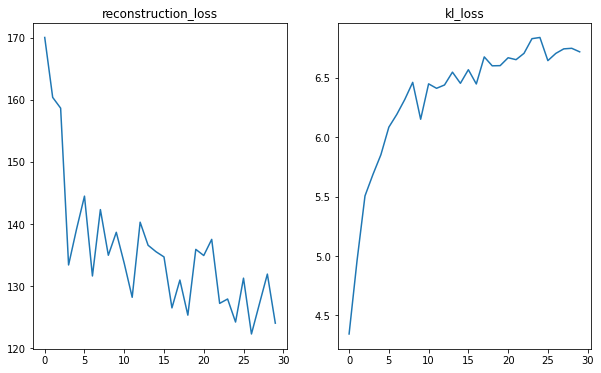

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)
plot_loss(history)

## Exercise 5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

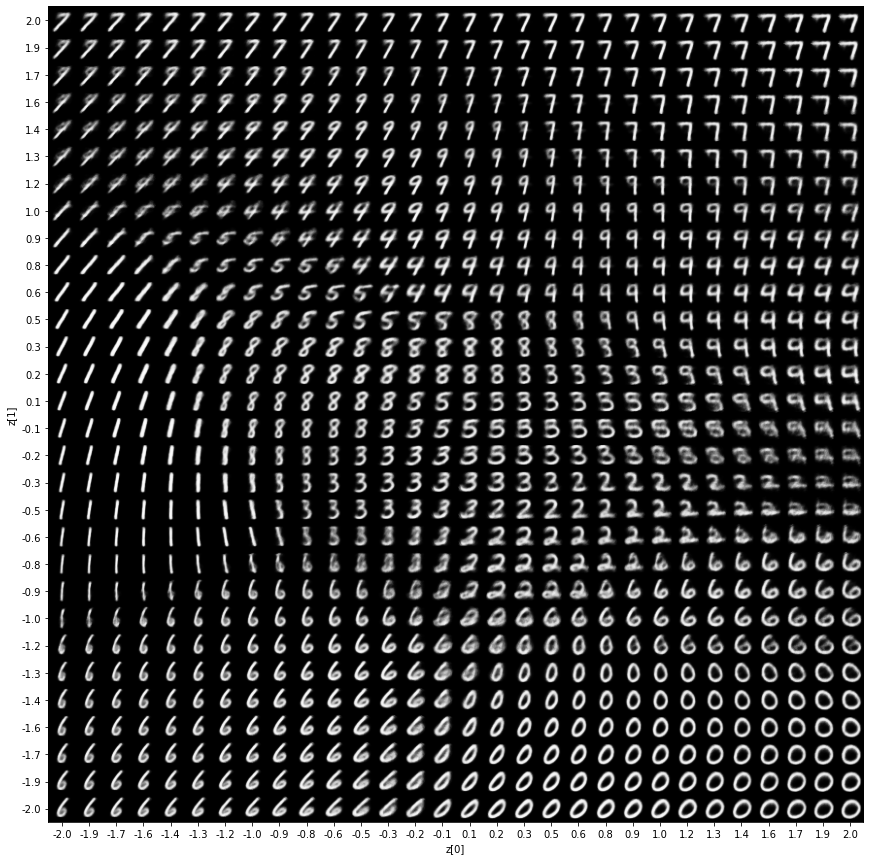

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

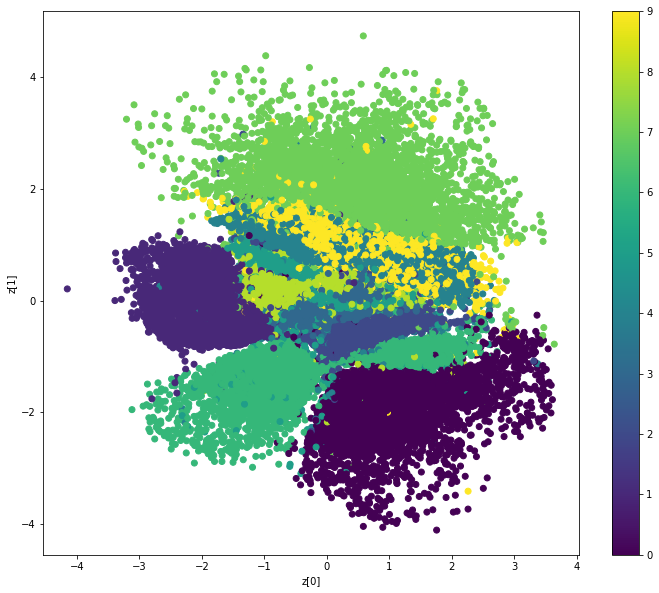

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

Now, I will show you the discussion the obtained plots, and we will explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. You can see my comments under the plots.

## **Increasing the number of layers**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 256)          200960      ['input_3[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 128)          32896       ['dense_9[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 64)           8256        ['dense_10[0][0]']               
                                                                                            

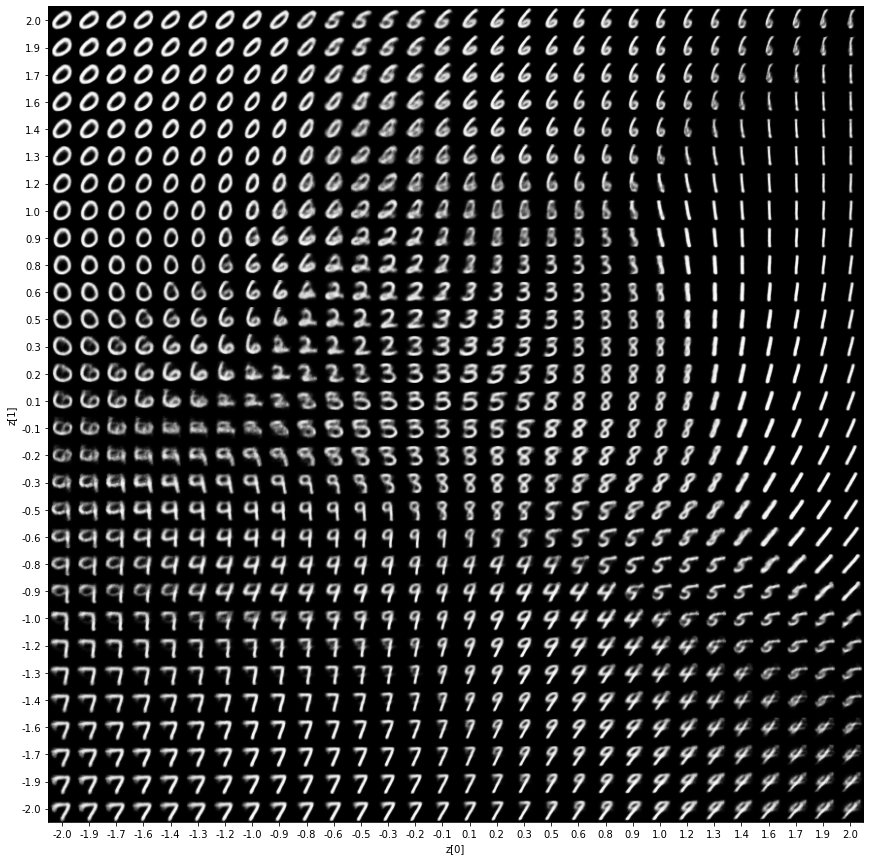

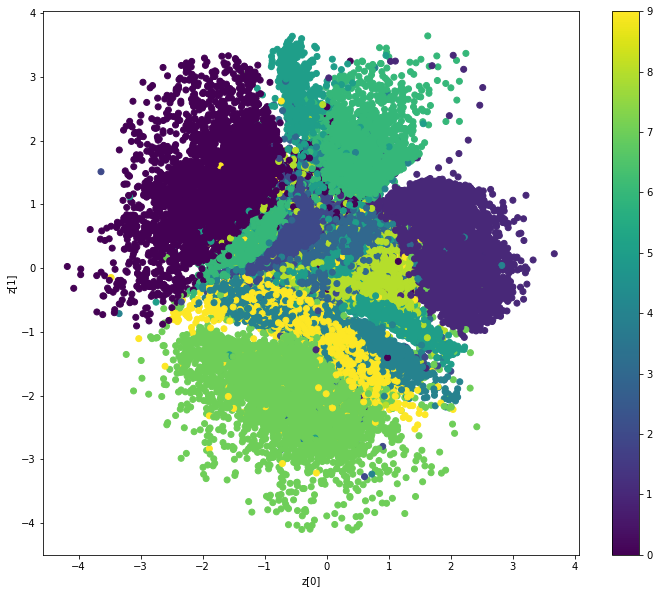

In [ ]:
# Model 1
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.Dense(32, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(32, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(256, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

## **Decreasing the number of layers**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 256)          200960      ['input_5[0][0]']                
                                                                                                  
 dense_21 (Dense)               (None, 128)          32896       ['dense_20[0][0]']               
                                                                                                  
 dense_22 (Dense)               (None, 2)            258         ['dense_21[0][0]']               
                                                                                            

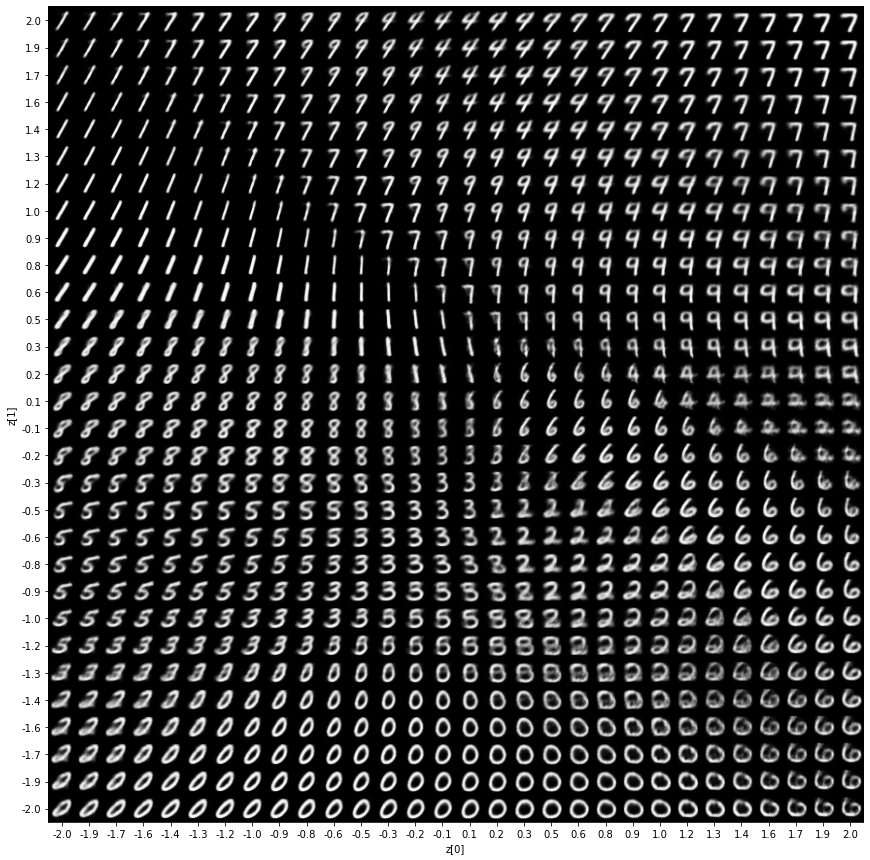

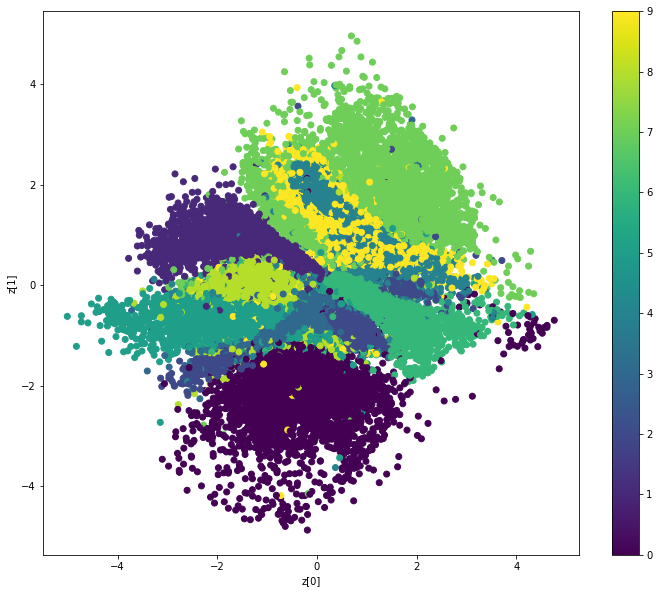

In [ ]:
# Model 2
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(128, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(256, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Increasing the number of layers in the model provides an improvement and the model is able to separate better the digits. Decreasing the number of layers don't help the model, because it has a less capacity to detect better the most important features of the digits. We can see by the plot that the most of the dots are overlapped among them.

## **Increasing the number of units**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 512)          401920      ['input_7[0][0]']                
                                                                                                  
 dense_28 (Dense)               (None, 128)          65664       ['dense_27[0][0]']               
                                                                                                  
 dense_29 (Dense)               (None, 64)           8256        ['dense_28[0][0]']               
                                                                                            

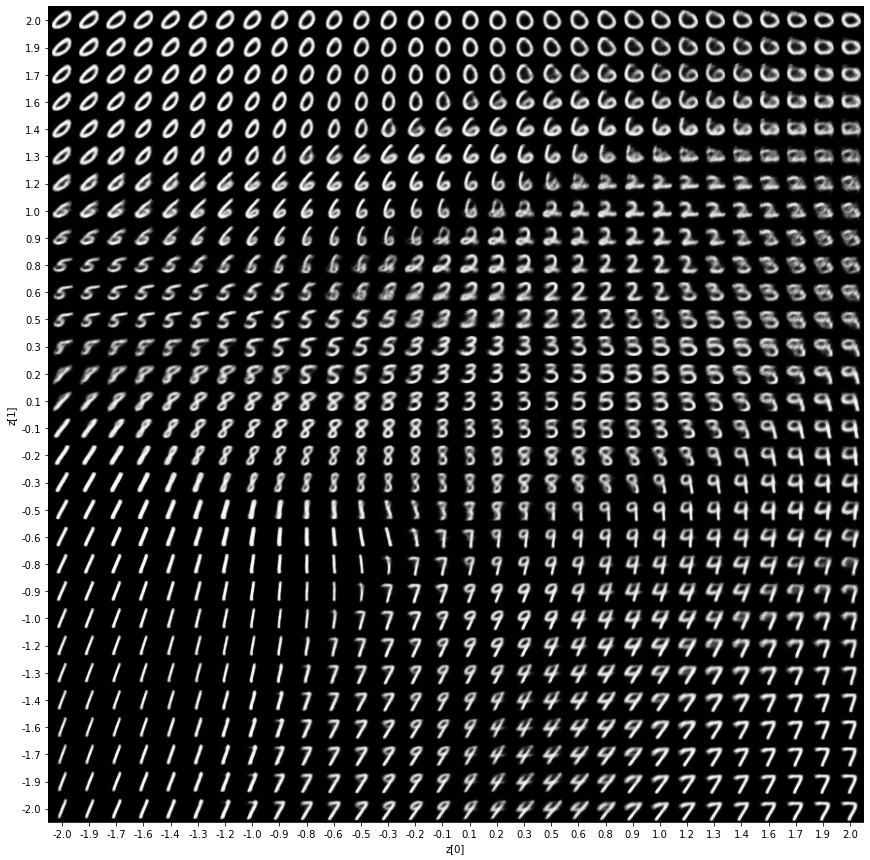

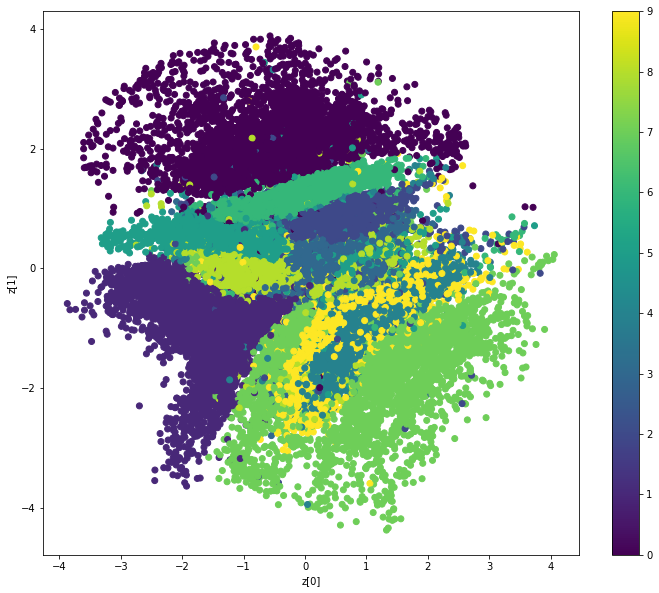

In [ ]:
# Model 3
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(512, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(512, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

## **Decreasing the number of units**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 256)          200960      ['input_9[0][0]']                
                                                                                                  
 dense_37 (Dense)               (None, 128)          32896       ['dense_36[0][0]']               
                                                                                                  
 dense_38 (Dense)               (None, 32)           4128        ['dense_37[0][0]']               
                                                                                            

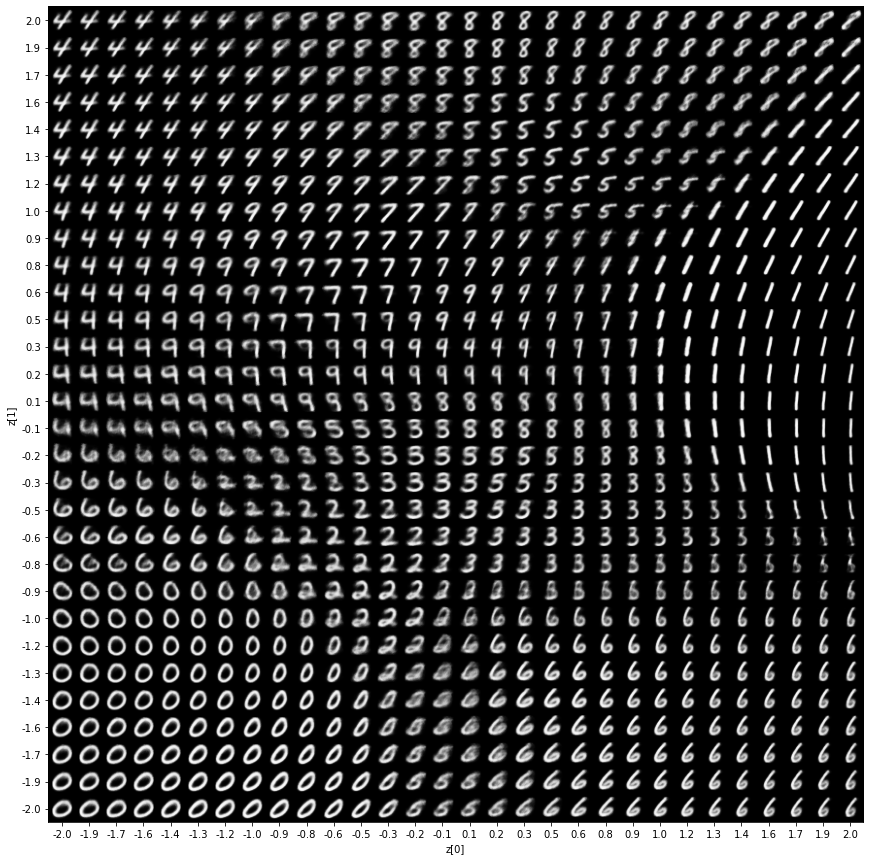

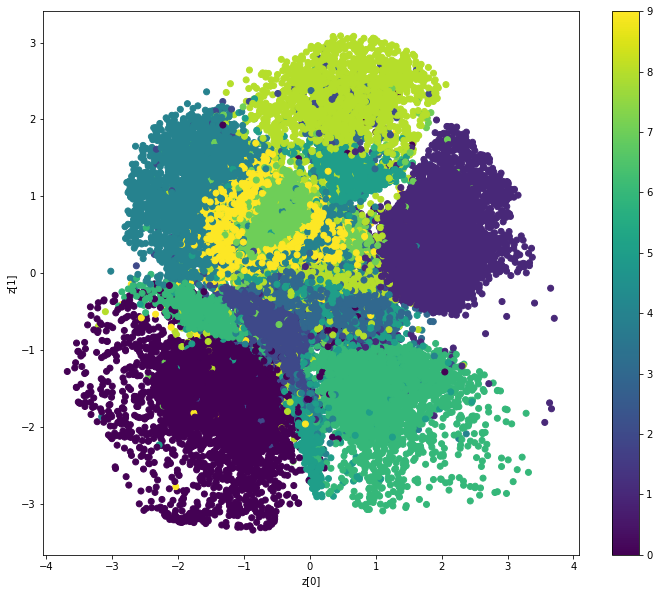

In [ ]:
# Model 4
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(32, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(32, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(256, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Increasing the number of units allows the model to have more ability to separate and digits. Instead, decreasing the number of units, reduce the capacity of the model and, as we can see from the plots, the model produces a blurried version of the original digits or it produces a malformed version of the original ones.

## **Different Activation Function(ReLU)**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_45 (Dense)               (None, 256)          200960      ['input_11[0][0]']               
                                                                                                  
 dense_46 (Dense)               (None, 128)          32896       ['dense_45[0][0]']               
                                                                                                  
 dense_47 (Dense)               (None, 64)           8256        ['dense_46[0][0]']               
                                                                                            

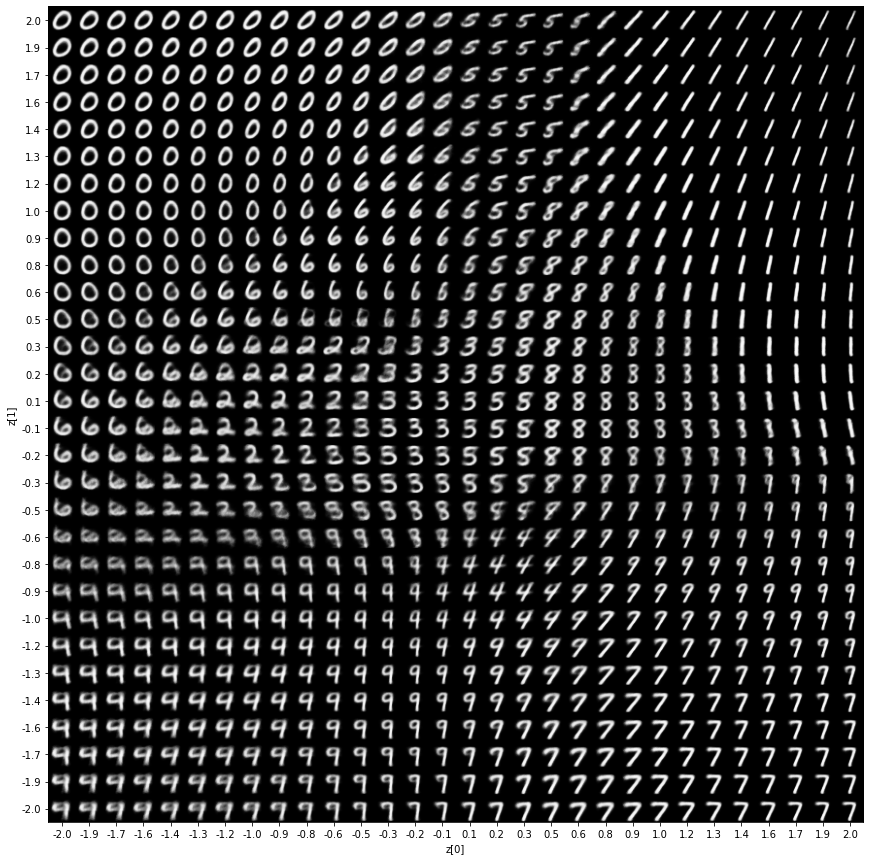

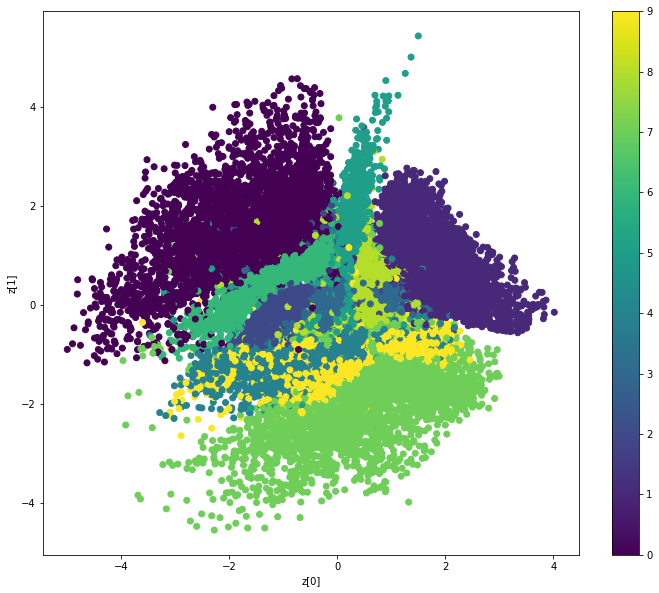

In [ ]:
# Model 5
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

## **Different Activation Function(Sigmoid)**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_54 (Dense)               (None, 256)          200960      ['input_13[0][0]']               
                                                                                                  
 dense_55 (Dense)               (None, 128)          32896       ['dense_54[0][0]']               
                                                                                                  
 dense_56 (Dense)               (None, 64)           8256        ['dense_55[0][0]']               
                                                                                            

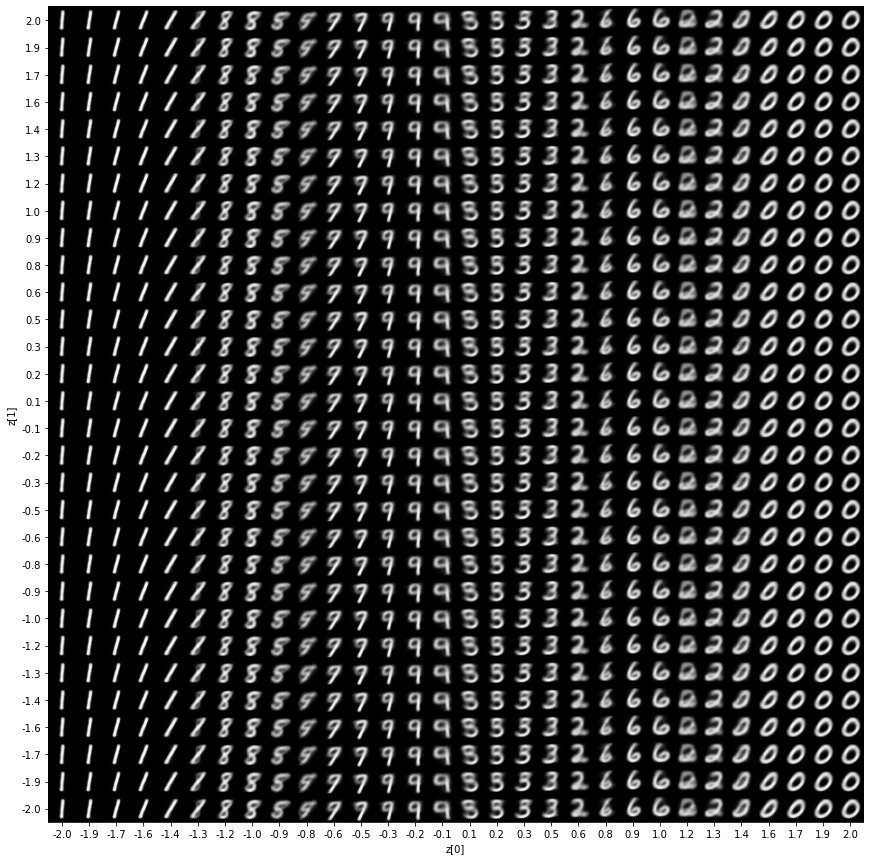

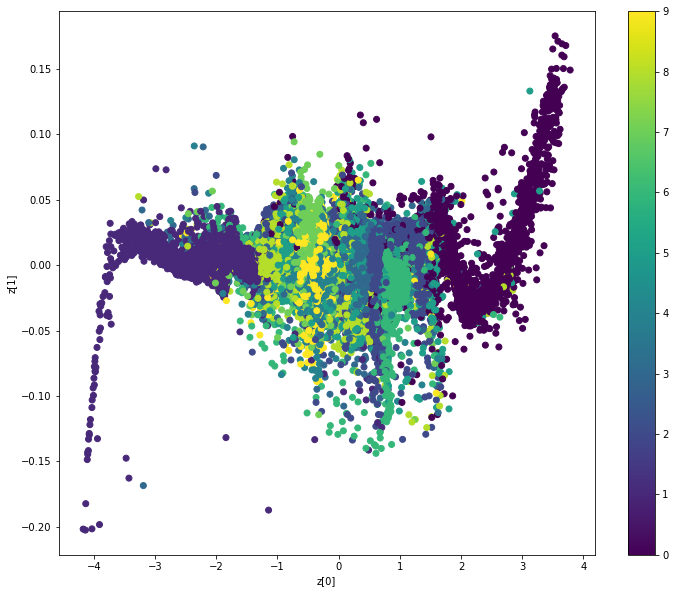

In [ ]:
# Model 6
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='sigmoid')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='sigmoid')(x)
x = tf.keras.layers.Dense(64, activation='sigmoid')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='sigmoid')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='sigmoid')(x)
x = tf.keras.layers.Dense(256, activation='sigmoid')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Using the ReLU activation function seems to produce a similar result to the original one. The reasons could be:

- It's a function that cope at the vanishing problem, because the gradient is always a constant: the derivative of ***f(x) = 0*** is 0 while the derivative of ***f(x) = x*** is 1;

- It needs less computational resources than sigmoid and tanh. The function needs to be executed to arrive at ReLU is a max function: ***max(0,x)*** produces 0 when ***x < 0*** and ***x*** when ***x >= 0***. Computing the output of a max function is simpler and less computationally expensive than computing the output of exponents (such as tanh and sigmoid). For one calculation, this does not matter much, but in deep learning many such calculations are made.

The model with the sigmoid as an activation function produces slightly worse results than the original model. The reason could be by the architecture of the model: the depth of the model could manifest the disappearance problem, a problem this function suffers from. Reducing the number of layers could reduce this problem.